In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModel, \
  BitsAndBytesConfig, GPTQConfig
import os

while "notebooks" in os.getcwd():
    os.chdir("..")

from time import time
from pathlib import Path
from tqdm import tqdm
import torch
from langdetect import detect
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from huggingface_hub import notebook_login
from datasets import load_dataset
import math
from typing import List, Optional, Tuple, Union
from torch import nn
from tqdm import tqdm
from IPython.display import clear_output
import warnings
from bert_score import BERTScorer
warnings.filterwarnings("ignore")
from copy import deepcopy
from openai import OpenAI

from src.utils import rotate_half, apply_rotary_pos_emb, repeat_kv, \
    get_context_length, insert_needle

from src.attention_saver import Mistral7BAttentionSaver

import scienceplots
plt.style.use(['science','no-latex'])

In [3]:
tokenizer = AutoTokenizer.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.1",
    cache_dir = "/Data"    
)

# Experiment 1 - Augment the attention on the needle

### 1.a) 

Prompt:

``` bash
<question>
	{q}
</question>

{context (with needle)}  

<question>
	{q}
</question>
```

In [3]:
base_path = "data/study-03-finding_needles/{model_name}/generated_text_delta={delta_attention}.parquet"
checkpoint_path = "data/study-03-finding_needles/{model_name}/checkpoints/generated_text_delta={delta_attention}.parquet"
model_name = "Mistral-7B-Instruct-v0.1"
experiment_name = '1.a'

needle = "\nThe best thing to do in San Francisco is eat a sandwich and sit in Dolores Park on a sunny day.\n"
question = "What is the best thing to do in San Francisco?"

In [4]:
tqdm.pandas()
df = load_dataset("stas/openwebtext-10k", cache_dir="/Data")['train'].to_pandas()
df["text_len"] = df["text"].apply(lambda x: len(x.split(" ")))
df['context_length'] = df['text'].progress_apply(get_context_length, tokenizer = tokenizer)

chunks = []
for n in range (9):
    samples = df.query(f"context_length > {500*n} & context_length < {500*(n+1)}")\
        .sample(50, random_state = 42)
    
    chunks.append(samples)

study_df = pd.concat(chunks)\
    .sort_values("context_length", ascending = False)


all_df = []

for depth_percent in tqdm(range(0, 110, 10)):

    percent_df = study_df.apply(
        insert_needle, 
        depth_percent = depth_percent, 
        question = question,
        needle = needle, 
        axis = 1
    )

    all_df.append(percent_df)

needle_in_a_haystack_df = pd.concat(all_df)\
    .reset_index(drop = True)

NameError: name 'tokenizer' is not defined

In [ ]:
all_df = []
for delta_attention in [0., 0.25, 0.5, 1.]:
    try:
        df = pd.read_parquet(
            base_path.format(model_name = model_name, delta_attention = delta_attention)
        )

    except:
        df = pd.read_parquet(
            checkpoint_path.format(model_name = model_name, delta_attention = delta_attention)
        )

    df['delta'] = delta_attention
    df = pd.merge(
        df,
        needle_in_a_haystack_df[['depth', 'text']],
        left_index= True,
        right_index=True
    )

    all_df.append(df)

In [ ]:
results_df = pd.concat(all_df)\
    .reset_index(drop = True)

In [10]:
results_df['context'] = results_df['generated_text']\
    .apply(lambda x: x[0].split("[/INST]")[0].split("[INST]")[1])
results_df['generated_text'] = results_df['generated_text']\
    .apply(lambda x: x[0].split("[/INST]")[1])

results_df.head()

,generated_text,target,question,context_length,text_index,delta,depth,text,depth_x,depth_y,context
0,The best thing to do in San Francisco is to s...,\nThe best thing to do in San Francisco is eat...,What is the best thing to do in San Francisco?,4491,0,0.0,0.0,Sitting down for the first time with reporters...,NaN,NaN,\n<question>\nWhat is the best thing to do in...
1,The best thing to do in San Francisco is to s...,\nThe best thing to do in San Francisco is eat...,What is the best thing to do in San Francisco?,4476,1,0.0,0.0,Despite Michael Atiyah’s many accolades — he i...,NaN,NaN,\n<question>\nWhat is the best thing to do in...
2,The best thing to do in San Francisco is to v...,\nThe best thing to do in San Francisco is eat...,What is the best thing to do in San Francisco?,4458,2,0.0,0.0,Preface\n\nTerminology for 18650 batteries can...,NaN,NaN,\n<question>\nWhat is the best thing to do in...
3,The best thing to do in San Francisco is to s...,\nThe best thing to do in San Francisco is eat...,What is the best thing to do in San Francisco?,4439,3,0.0,0.0,"GTA V Benchmarked Florian Glaser , ✓ Tanja Hin...",NaN,NaN,\n<question>\nWhat is the best thing to do in...
4,The best thing to do in San Francisco is to e...,\nThe best thing to do in San Francisco is eat...,What is the best thing to do in San Francisco?,4402,4,0.0,0.0,"Chapter 39\n\n""I could just take care of both ...",NaN,NaN,\n<question>\nWhat is the best thing to do in...


In [11]:
results_df['score'] = results_df['generated_text'].apply(lambda x: 'dolores' in x.lower())

In [12]:
mask = results_df.groupby("text")\
    .score\
    .mean()\
    .rename("text_quality")



results_df = pd.merge(
    results_df,
    mask,
    left_on=['text'],
    right_index=True
).query("text_quality >=0")


In [13]:
results_df['context_length_bins'] = pd.cut(
    results_df['context_length'],
    range(0, 4_500, 500)
)

results_df['depth'] = results_df['depth'].fillna(results_df['depth_x'])

results_df['depth_bins'] = pd.cut(
    results_df['depth'],
    range(0,110,10),
    include_lowest = True
)

(0.0, 1.0)

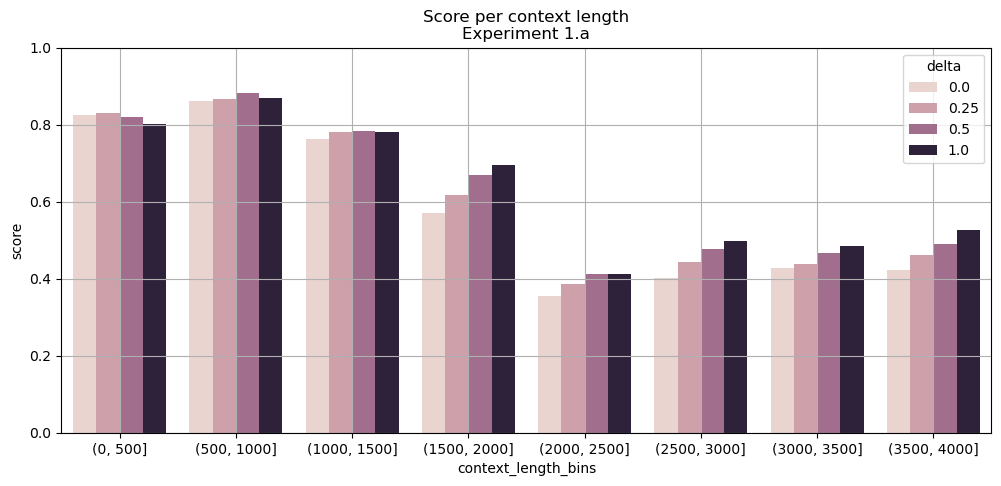

In [14]:
performance_df = results_df\
    .groupby(['delta', "context_length_bins"])\
    .score\
    .mean()\
    .reset_index()

plt.figure(figsize=(12,5))

sns.barplot(
    performance_df,
    x = 'context_length_bins',
    y = "score",
    hue = "delta"
)

plt.title(f"Score per context length\nExperiment {experiment_name}")
plt.grid()
plt.ylim([0,1])

(0.0, 1.0)

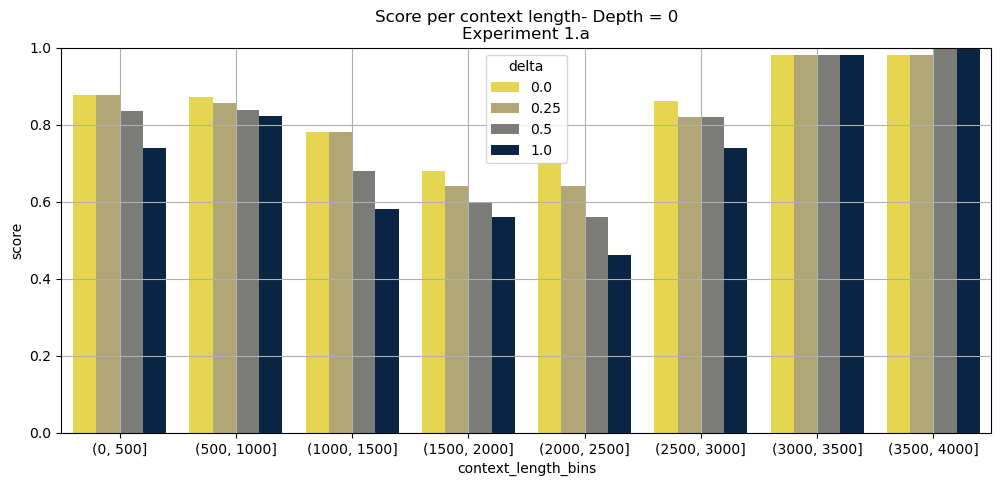

In [15]:
performance_df = results_df\
    .query("depth == 0")\
    .groupby(['delta', "context_length_bins"])\
    .score\
    .mean()\
    .reset_index()

plt.figure(figsize=(12,5))

sns.barplot(
    performance_df,
    x = 'context_length_bins',
    y = "score",
    hue = "delta",
    palette = 'cividis_r'
)

plt.title(f"Score per context length- Depth = 0\nExperiment {experiment_name}")
plt.grid()

plt.ylim([0,1])

(0.0, 1.0)

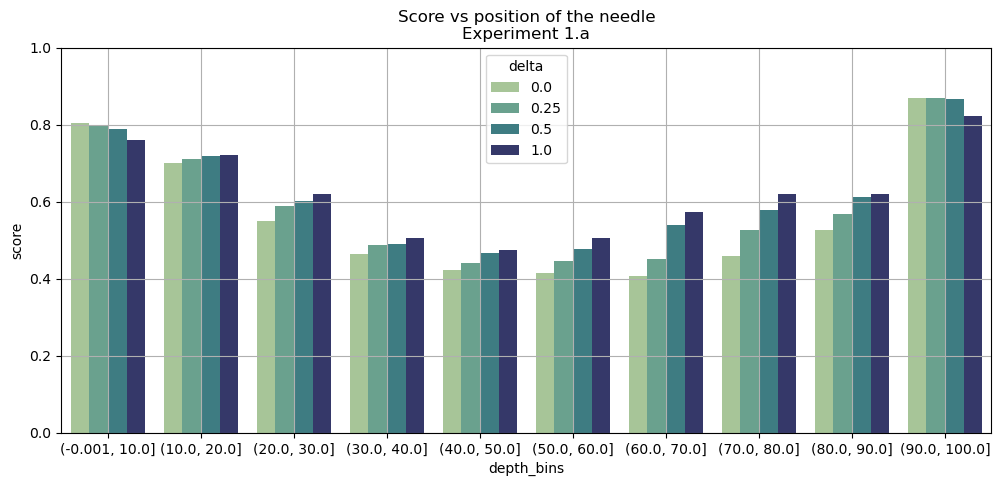

In [16]:
performance_df = results_df\
    .groupby(['delta', "depth_bins"])\
    .score\
    .mean()\
    .reset_index()

plt.figure(figsize=(12,5))

sns.barplot(
    performance_df,
    x = 'depth_bins',
    y = "score",
    hue = "delta",
    palette = "crest"
)

plt.title(f"Score vs position of the needle\nExperiment {experiment_name}")
plt.grid()
plt.ylim([0,1])

In [17]:
performance_df = results_df\
    .groupby(['delta', "context_length_bins", "depth_bins"])\
    .score\
    .mean()\
    .reset_index()

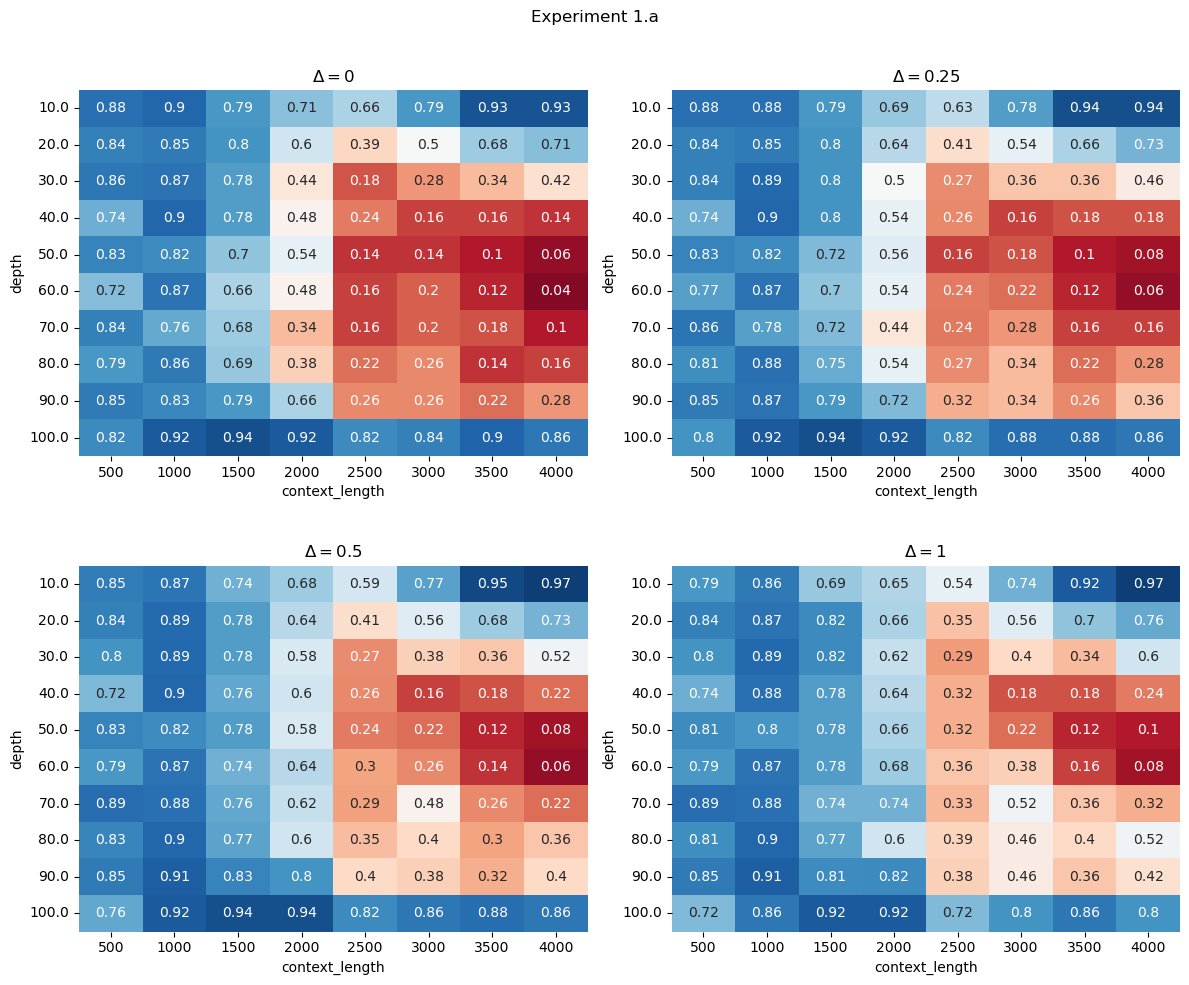

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# List of delta values for each subplot
delta_values = [0, 0.25,0.5, 1]

# Loop over the subplots and delta values
for ax, delta in zip(axes.flat, delta_values):
    heatmap_data = performance_df.query(
        f"delta == {delta}")

    heatmap_data['depth_bins'] = heatmap_data['depth_bins']\
    .apply(lambda x : x.right)

    heatmap_data['context_length_bins'] = heatmap_data['context_length_bins']\
        .apply(lambda x : x.right)

    heatmap_data = heatmap_data\
        .pivot(index="depth_bins", columns="context_length_bins", values="score",)
    
    sns.heatmap(heatmap_data, ax=ax, cmap="RdBu", annot=True, cbar=False, vmin = 0, vmax = 1)
    ax.set_xlabel("context_length")
    ax.set_ylabel("depth")
    ax.set_title(rf"$\Delta = {delta}$")

# Adjust layout
plt.tight_layout()

plt.suptitle(f"Experiment {experiment_name}")
plt.subplots_adjust(top = 0.9)
plt.subplots_adjust(hspace=0.3)

# Show the plot
plt.show()

### 1.b)

Prompt

``` bash
{context (with needle)}
  
{q} based on the text? Don't give information outside the document or repeat our findings
```

In [19]:
base_path = "data/study-03-finding_needles/{model_name}/02/generated_text_delta={delta_attention}.parquet"
checkpoint_path = "data/study-03-finding_needles/{model_name}/02/checkpoints/generated_text_delta={delta_attention}.parquet"
model_name = "Mistral-7B-Instruct-v0.1"
experiment_name= "1.b"

needle = "\nThe best thing to do in San Francisco is eat a sandwich and sit in Dolores Park on a sunny day.\n"
question = "What is the best thing to do in San Francisco?"

In [20]:
all_df = []
for delta_attention in [0., 0.25, 0.5, 1.]:
    try:
        df = pd.read_parquet(
            base_path.format(model_name = model_name, delta_attention = delta_attention)
        )

    except:
        df = pd.read_parquet(
            checkpoint_path.format(model_name = model_name, delta_attention = delta_attention)
        )

    df['delta'] = delta_attention
    all_df.append(df)

In [21]:
results_df = pd.concat(all_df)\
    .reset_index(drop = True)

In [22]:
results_df['context'] = results_df['generated_text']\
    .apply(lambda x: x[0].split("[/INST]")[0].split("[INST]")[1])
results_df['generated_text'] = results_df['generated_text']\
    .apply(lambda x: x[0].split("[/INST]")[1])

results_df.head()

,generated_text,target,question,context_length,depth,text_index,delta,context
0,"The House Majority Leader, Gerald McCormick, ...",\nThe best thing to do in San Francisco is eat...,What is the most fun thing to do in San Franci...,4491,0.0,0,0.0,\nThe best thing to do in San Francisco is e...
1,The most fun thing to do in San Francisco bas...,\nThe best thing to do in San Francisco is eat...,What is the most fun thing to do in San Franci...,4476,0.0,1,0.0,\nThe best thing to do in San Francisco is e...
2,The most fun thing to do in San Francisco bas...,\nThe best thing to do in San Francisco is eat...,What is the most fun thing to do in San Franci...,4458,0.0,2,0.0,\nThe best thing to do in San Francisco is e...
3,The most fun thing to do in San Francisco bas...,\nThe best thing to do in San Francisco is eat...,What is the most fun thing to do in San Franci...,4439,0.0,3,0.0,\nThe best thing to do in San Francisco is e...
4,The most fun thing to do in San Francisco bas...,\nThe best thing to do in San Francisco is eat...,What is the most fun thing to do in San Franci...,4402,0.0,4,0.0,\nThe best thing to do in San Francisco is e...


In [23]:
results_df['score'] = results_df['generated_text'].apply(lambda x: 'dolores' in x.lower())

In [24]:
results_df['context_length_bins'] = pd.cut(
    results_df['context_length'],
    range(0, 4_500, 500)
)

# results_df['depth'] = results_df['depth'].fillna(results_df['depth_x'])

results_df['depth_bins'] = pd.cut(
    results_df['depth'],
    range(0,110,10),
    include_lowest = True
)

(0.0, 1.0)

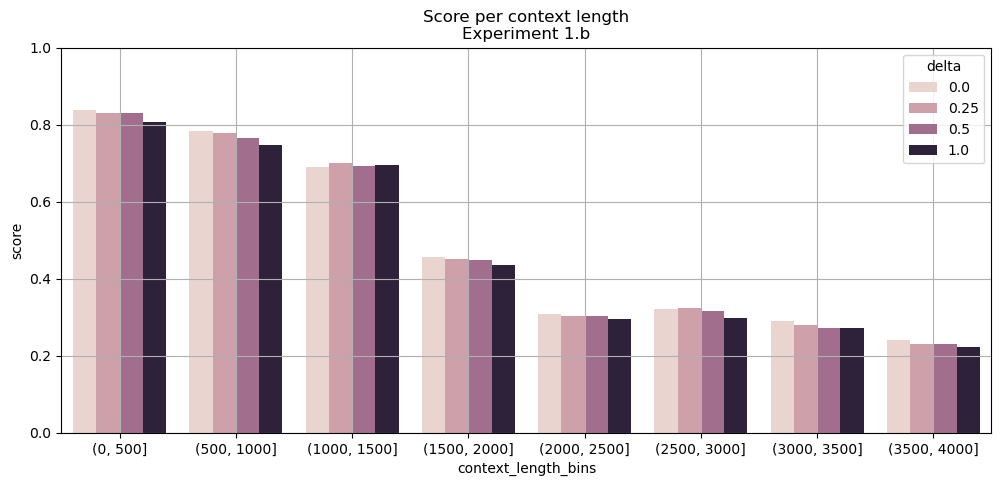

In [25]:
performance_df = results_df\
    .groupby(['delta', "context_length_bins"])\
    .score\
    .mean()\
    .reset_index()

plt.figure(figsize=(12,5))

sns.barplot(
    performance_df,
    x = 'context_length_bins',
    y = "score",
    hue = "delta"
)

plt.title(f"Score per context length\nExperiment {experiment_name}")
plt.grid()
plt.ylim([0,1])

(0.0, 1.0)

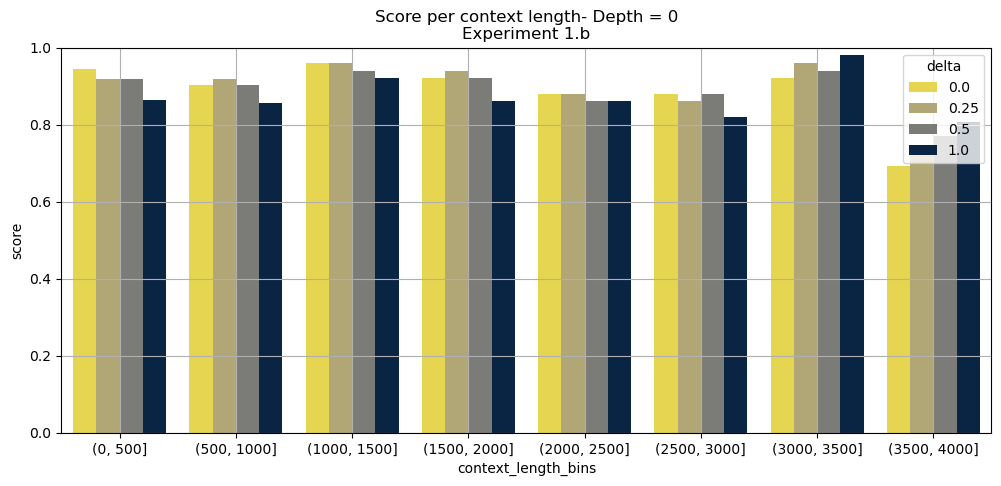

In [26]:
performance_df = results_df\
    .query("depth == 0")\
    .groupby(['delta', "context_length_bins"])\
    .score\
    .mean()\
    .reset_index()

plt.figure(figsize=(12,5))

sns.barplot(
    performance_df,
    x = 'context_length_bins',
    y = "score",
    hue = "delta",
    palette = 'cividis_r'
)

plt.title(f"Score per context length- Depth = 0\nExperiment {experiment_name}")
plt.grid()
plt.ylim([0,1])

(0.0, 1.0)

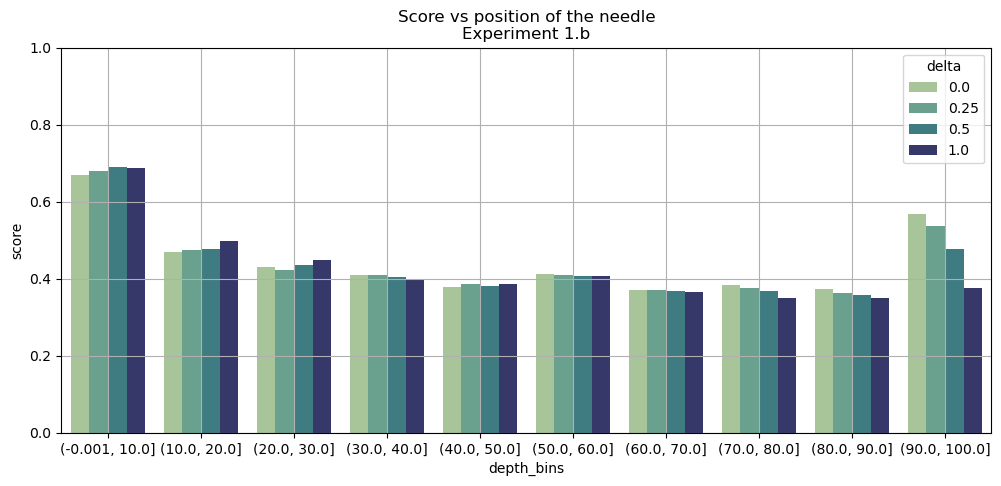

In [27]:
performance_df = results_df\
    .groupby(['delta', "depth_bins"])\
    .score\
    .mean()\
    .reset_index()

plt.figure(figsize=(12,5))

sns.barplot(
    performance_df,
    x = 'depth_bins',
    y = "score",
    hue = "delta",
    palette = "crest"
)

plt.title(f"Score vs position of the needle\nExperiment {experiment_name}")
plt.grid()
plt.ylim([0,1])

In [28]:
performance_df = results_df\
    .groupby(['delta', "context_length_bins", "depth_bins"])\
    .score\
    .mean()\
    .reset_index()

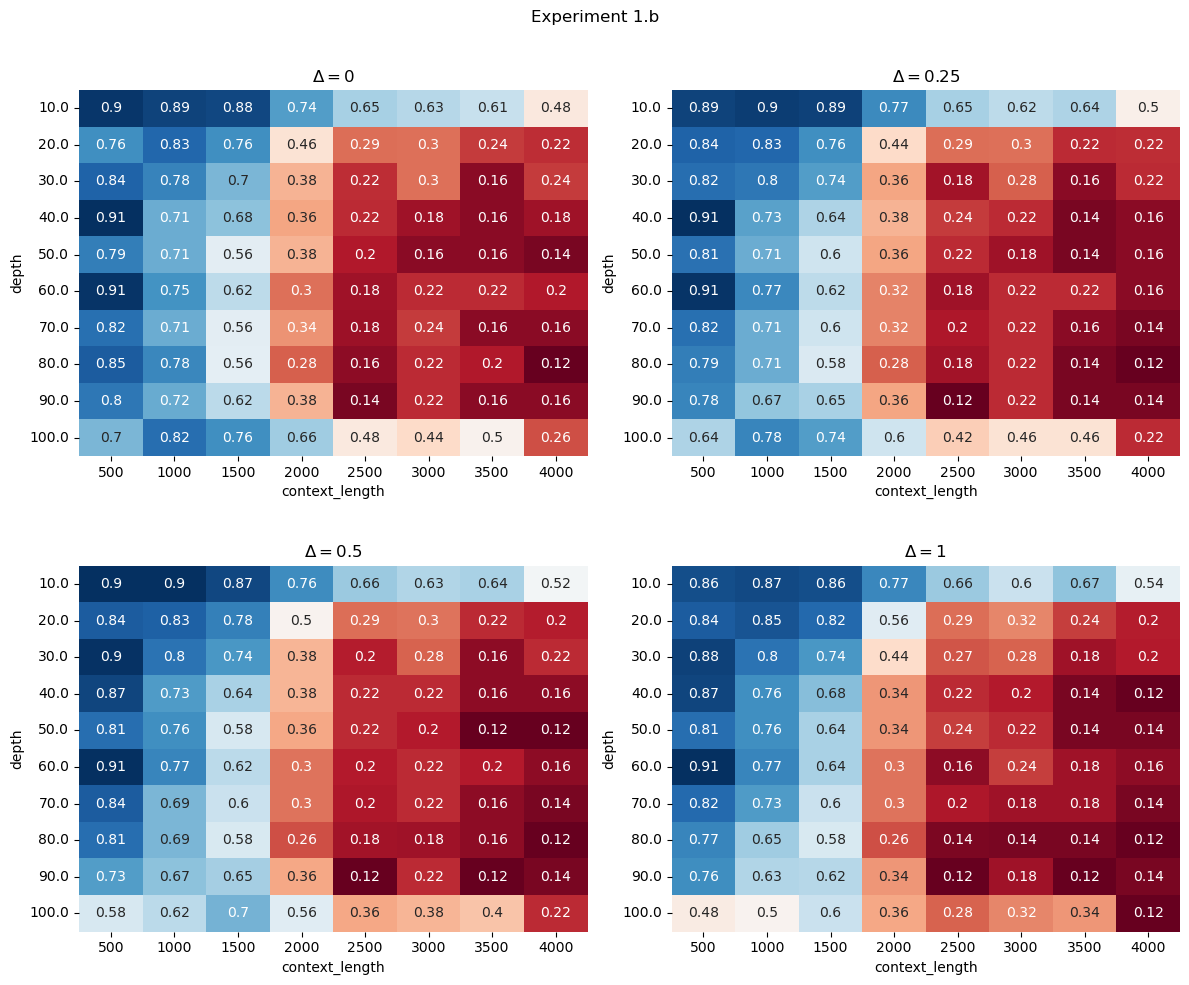

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# List of delta values for each subplot
delta_values = [0, 0.25,0.5, 1]

# Loop over the subplots and delta values
for ax, delta in zip(axes.flat, delta_values):
    heatmap_data = performance_df.query(
        f"delta == {delta}")

    heatmap_data['depth_bins'] = heatmap_data['depth_bins']\
    .apply(lambda x : x.right)

    heatmap_data['context_length_bins'] = heatmap_data['context_length_bins']\
        .apply(lambda x : x.right)

    heatmap_data = heatmap_data\
        .pivot(index="depth_bins", columns="context_length_bins", values="score")
    
    sns.heatmap(heatmap_data, ax=ax, cmap="RdBu", annot=True, cbar=False)
    ax.set_xlabel("context_length")
    ax.set_ylabel("depth")
    ax.set_title(rf"$\Delta = {delta}$")

# Adjust layout
plt.tight_layout()

plt.suptitle(f"Experiment {experiment_name}")
plt.subplots_adjust(top = 0.9)
plt.subplots_adjust(hspace=0.3)

# Show the plot
plt.show()

### 1.c)

``` bash
<question>
Your objective is to answer to the following question based on the context :

{q}

Don't give information outside the document or repeat our findings
</question>

<context with needle>

<question>
Your objective is to answer to the following question based on the context :

{q}

Don't give information outside the document or repeat our findings
</question>
```

In [4]:
base_path = "data/study-03-finding_needles/{model_name}/06/generated_text_delta={delta_attention}.parquet"
checkpoint_path = "data/study-03-finding_needles/{model_name}/06/checkpoints/generated_text_delta={delta_attention}.parquet"
model_name = "Mistral-7B-Instruct-v0.1"
experiment_name = '1.c'

needle = "\nThe best thing to do in San Francisco is eat a sandwich and sit in Dolores Park on a sunny day.\n"
question = "What is the best thing to do in San Francisco?"

In [5]:
all_df = []
for delta_attention in [0., 0.25, 0.5, 1.]:
    try:
        df = pd.read_parquet(
            base_path.format(model_name = model_name, delta_attention = delta_attention)
        )

    except:
        df = pd.read_parquet(
            checkpoint_path.format(model_name = model_name, delta_attention = delta_attention)
        )

    df['delta'] = delta_attention
    all_df.append(df)

In [6]:
results_df = pd.concat(all_df)\
    .reset_index(drop = True)

In [7]:
results_df['context'] = results_df['generated_text']\
    .apply(lambda x: x[0].split("[/INST]")[0].split("[INST]")[1])
results_df['generated_text'] = results_df['generated_text']\
    .apply(lambda x: x[0].split("[/INST]")[1])

results_df.head()

,generated_text,target,question,context_length,depth,text_index,delta,context
0,The best thing to do in San Francisco is to e...,\n\nThe best thing to do in San Francisco is e...,Your objective is to answer the following ques...,4402,0.0,0,0.0,\n<question>\nYour objective is to answer the...
1,"Based on the context, the best thing to do in...",\n\nThe best thing to do in San Francisco is e...,Your objective is to answer the following ques...,4388,0.0,1,0.0,\n<question>\nYour objective is to answer the...
2,The best thing to do in San Francisco is to s...,\n\nThe best thing to do in San Francisco is e...,Your objective is to answer the following ques...,4387,0.0,2,0.0,\n<question>\nYour objective is to answer the...
3,The best thing to do in San Francisco is to e...,\n\nThe best thing to do in San Francisco is e...,Your objective is to answer the following ques...,4260,0.0,3,0.0,\n<question>\nYour objective is to answer the...
4,The best thing to do in San Francisco is to e...,\n\nThe best thing to do in San Francisco is e...,Your objective is to answer the following ques...,4256,0.0,4,0.0,\n<question>\nYour objective is to answer the...


In [8]:
results_df['score'] = results_df['generated_text'].apply(lambda x: 'dolores' in x.lower())

In [9]:
results_df['context_length_bins'] = pd.cut(
    results_df['context_length'],
    range(0, 4_500, 500)
)

results_df['depth_bins'] = pd.cut(
    results_df['depth'],
    range(-0,110,10),
    include_lowest = False
)

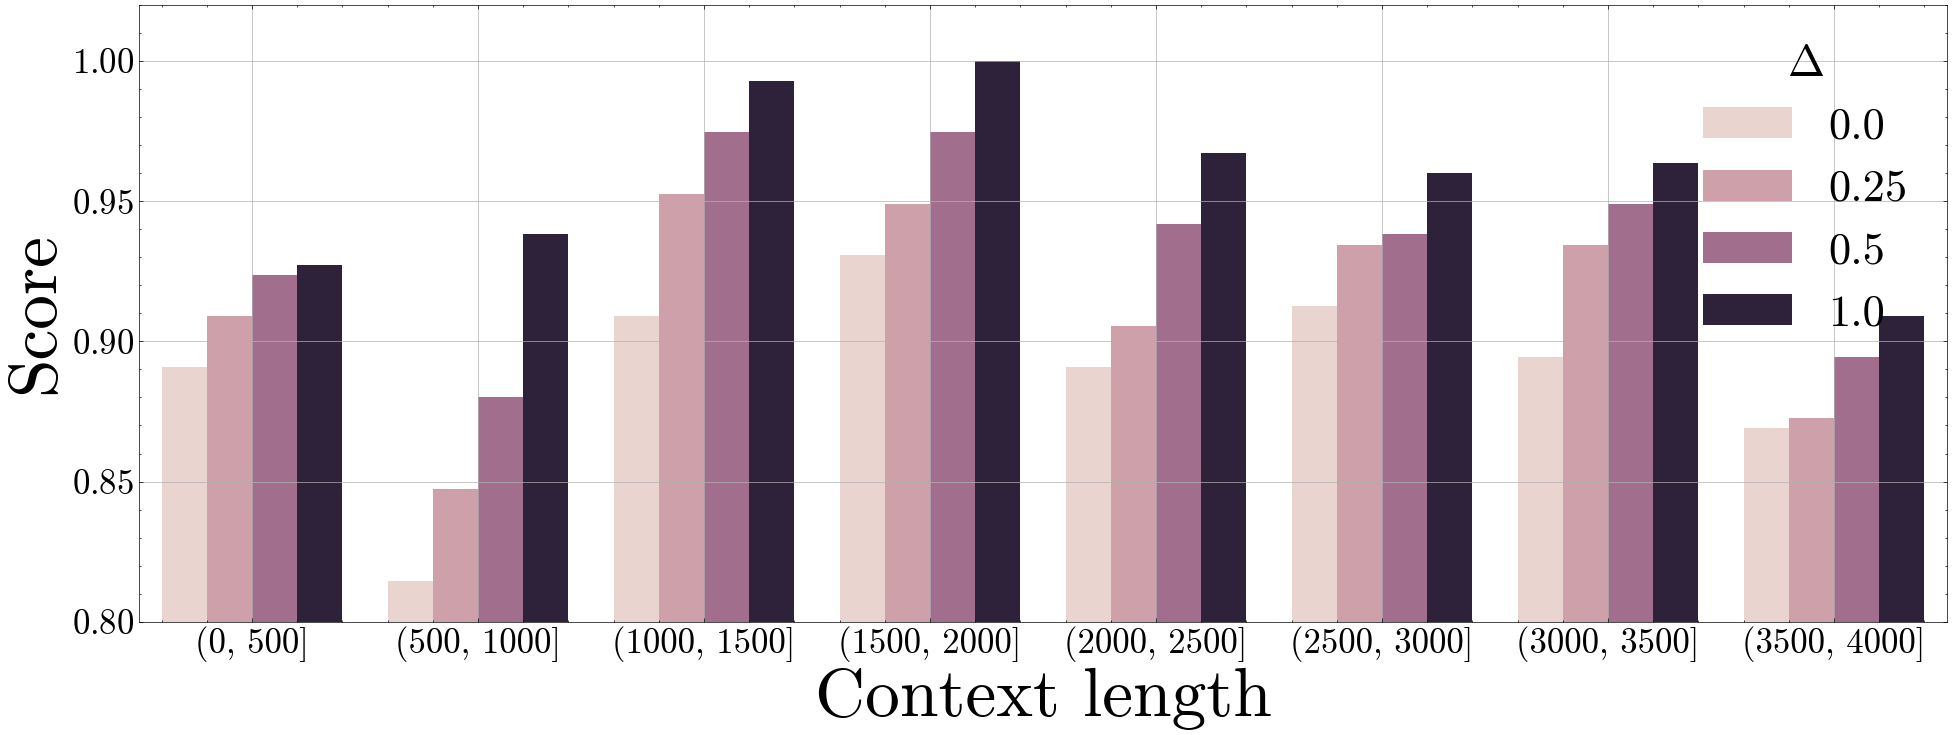

In [18]:
performance_df = results_df\
    .groupby(['delta', "context_length_bins"])\
    .score\
    .mean()\
    .reset_index()

plt.rc("font", size = 25)
plt.figure(figsize=(20,8))

ax = sns.barplot(
    performance_df,
    x = 'context_length_bins',
    y = "score",
    hue = "delta"
)

label_fontsize = 50
legend_fontsize = 32
tick_fontsize = 25

plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)

legend = plt.legend(prop= {"size" : legend_fontsize})
plt.setp(legend.get_title(),fontsize=legend_fontsize)

ax.legend_.set_title(r"$\Delta$")
plt.xlabel("Context length", fontsize = label_fontsize)
plt.ylabel("Score", fontsize = label_fontsize)

# plt.title(f"Score per context length\nExperiment {experiment_name}")
plt.grid()
plt.tight_layout()
plt.ylim([0.8,1.02])


plt.savefig("img/needle_delta_vs_context_length.pdf")

(0.0, 1.3)

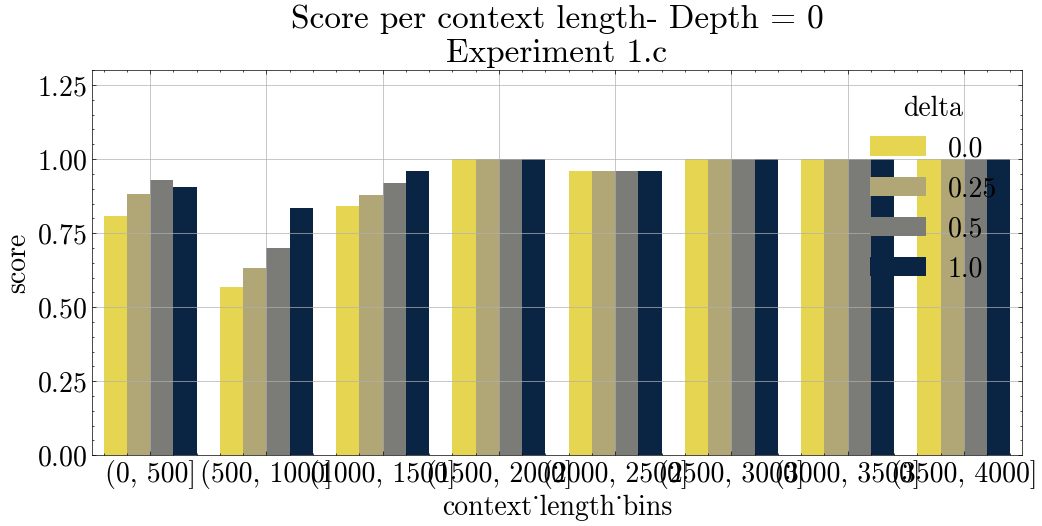

In [24]:
performance_df = results_df\
    .query("depth == 0")\
    .groupby(['delta', "context_length_bins"])\
    .score\
    .mean()\
    .reset_index()

plt.figure(figsize=(12,5))

sns.barplot(
    performance_df,
    x = 'context_length_bins',
    y = "score",
    hue = "delta",
    palette = 'cividis_r'
)

plt.title(f"Score per context length- Depth = 0\nExperiment {experiment_name}")
plt.grid()

plt.ylim([0,1.3])

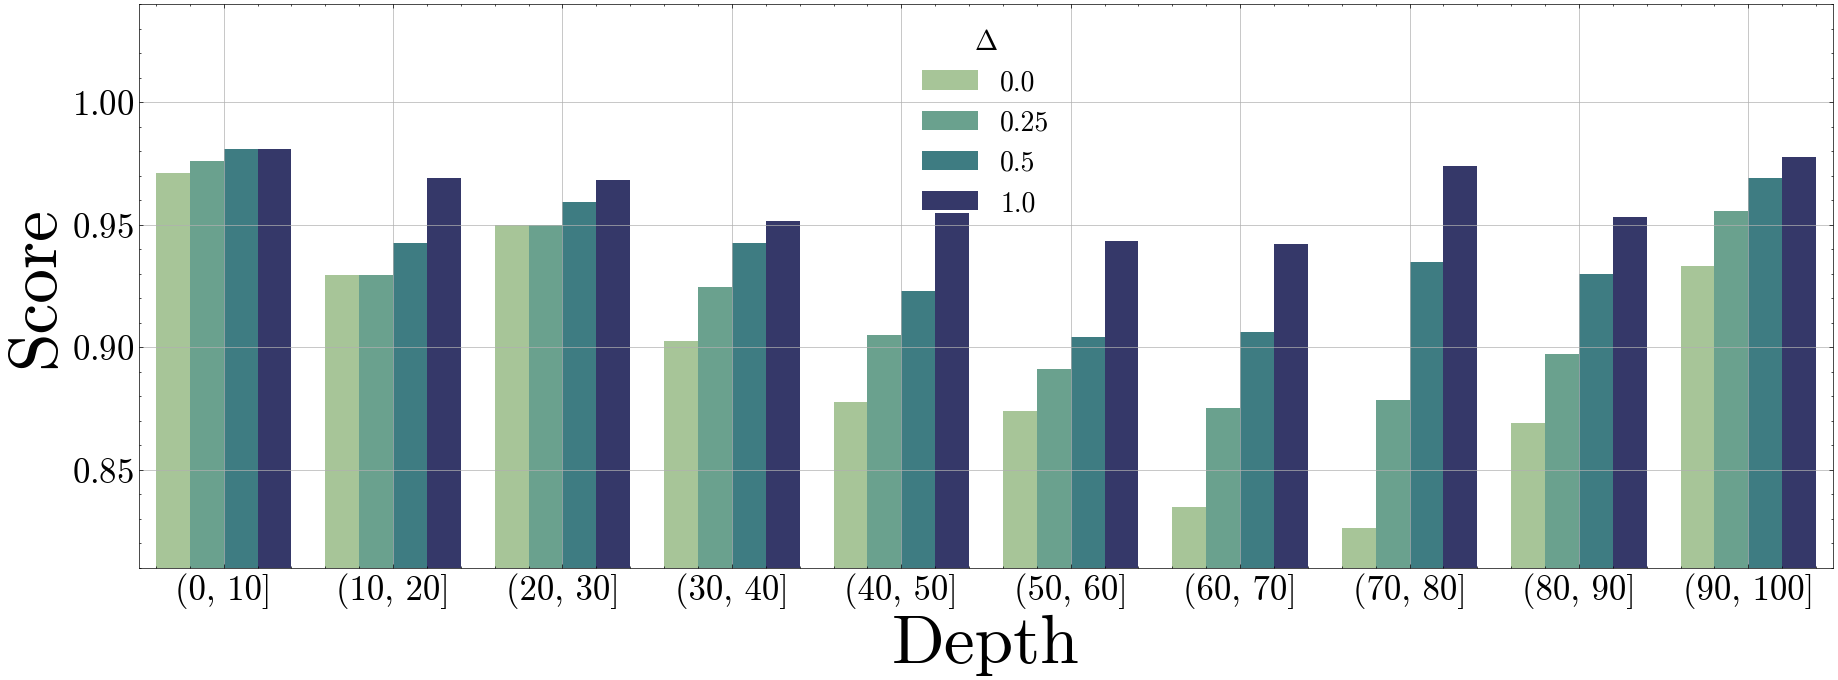

In [47]:
performance_df = results_df\
    .groupby(['delta', "depth_bins"])\
    .score\
    .mean()\
    .reset_index()

plt.rc("font", size = 40)
plt.figure(figsize=(20,8))

ax = sns.barplot(
    performance_df,
    x = 'depth_bins',
    y = "score",
    hue = "delta",
    palette = "crest"
)

ax.legend_.set_title(r"$\Delta$")

# plt.title(f"Score vs position of the needle\nExperiment {experiment_name}")
plt.grid()
plt.ylim([0.81,1.04])
plt.tight_layout()

label_fontsize = 50
legend_fontsize = 20
tick_fontsize = 25

plt.tick_params(axis='both', which='major', labelsize=tick_fontsize)

legend = plt.legend(prop= {"size" : legend_fontsize})
plt.setp(legend.get_title(),fontsize=legend_fontsize)

ax.legend_.set_title(r"$\Delta$")
plt.xlabel("Depth", fontsize = label_fontsize)
plt.ylabel("Score", fontsize = label_fontsize)
plt.savefig("img/needle_delta_vs_position.pdf")

In [49]:
performance_df = results_df\
    .groupby(['delta', "context_length_bins", "depth_bins"])\
    .score\
    .mean()\
    .reset_index()

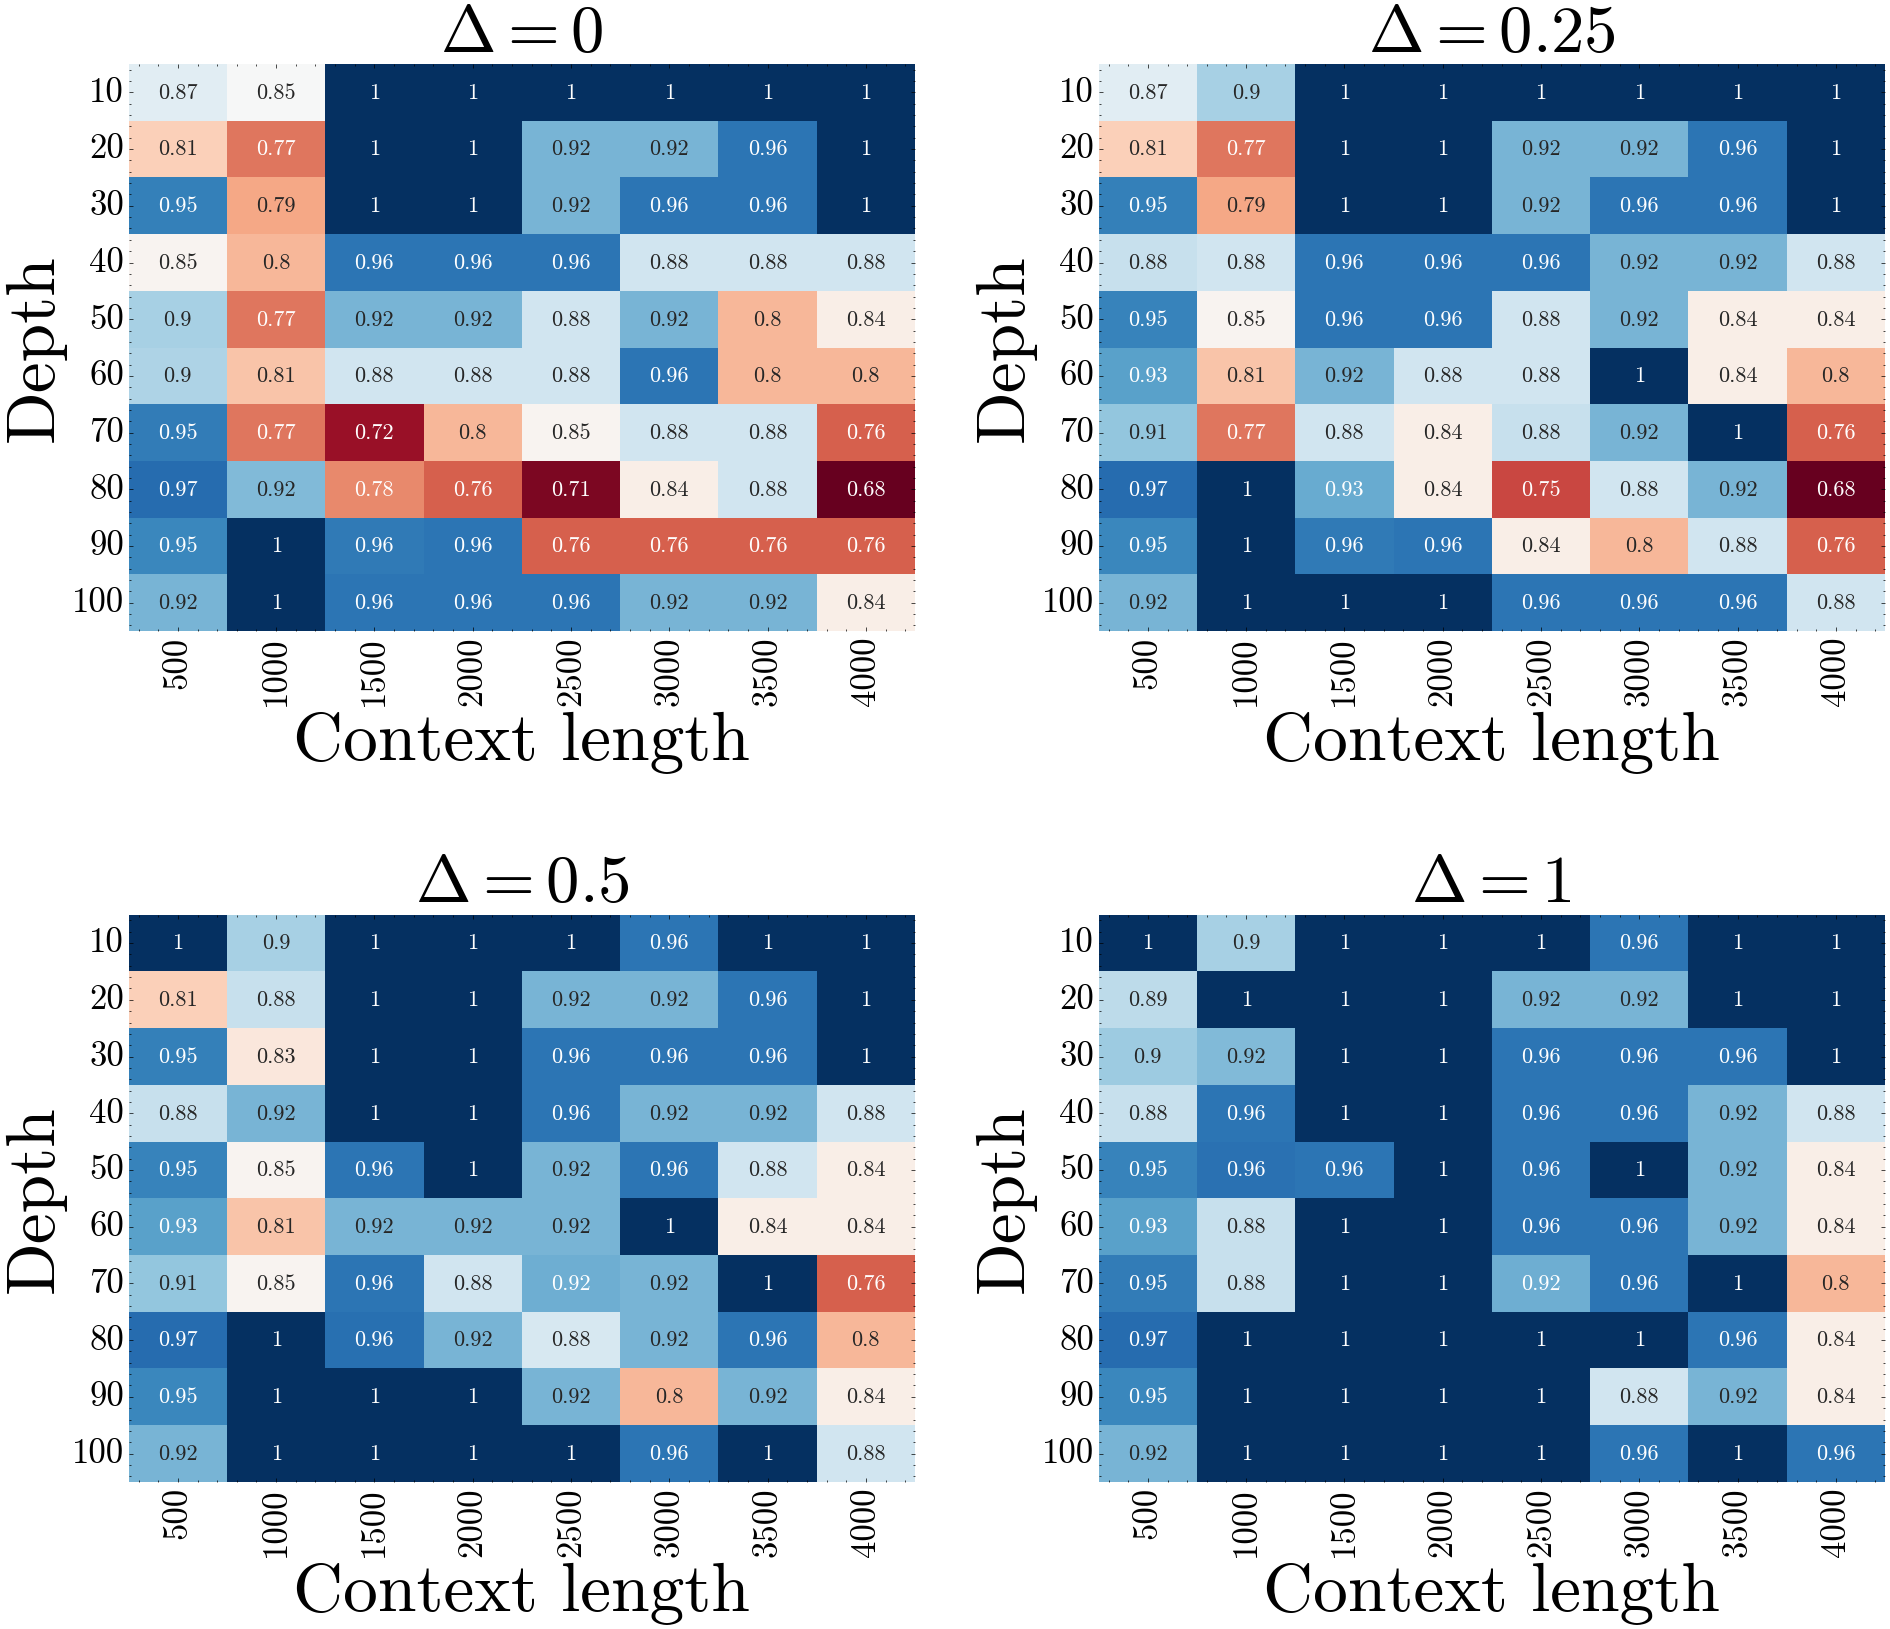

In [59]:
label_fontsize = 50
legend_fontsize = 20
tick_fontsize = 25
fig, axes = plt.subplots(2, 2, figsize=(20, 18))

# List of delta values for each subplot
delta_values = [0, 0.25,0.5, 1]

# Loop over the subplots and delta values
for ax, delta in zip(axes.flat, delta_values):
    heatmap_data = performance_df.query(
        f"delta == {delta}")

    heatmap_data['depth_bins'] = heatmap_data['depth_bins']\
    .apply(lambda x : x.right)

    heatmap_data['context_length_bins'] = heatmap_data['context_length_bins']\
        .apply(lambda x : x.right)

    heatmap_data = heatmap_data\
        .pivot(index="depth_bins", columns="context_length_bins", values="score",)
    
    sns.heatmap(heatmap_data, ax=ax, cmap="RdBu", annot=True, cbar=False, vmin = 0.7, vmax = 1, annot_kws={"size": 16})
    ax.set_xlabel("Context length", fontsize = label_fontsize)
    ax.set_ylabel("Depth", fontsize = label_fontsize)
    ax.set_title(rf"$\Delta = {delta}$")
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

# Adjust layout
plt.tight_layout()

# plt.suptitle(f"Experiment {experiment_name}")

plt.subplots_adjust(top = 0.9)
plt.subplots_adjust(hspace=0.5)
plt.savefig("img/needle_heatmap.pdf")
# Show the plot
plt.show()

### 1.d)  

Same prompt as 1.c but using same text

In [1]:
base_path = "data/study-03-finding_needles/{model_name}/delta-on-needle/08/generated_text_delta={delta_attention}.parquet"
checkpoint_path = "data/study-03-finding_needles/{model_name}/delta-on-needle/08/checkpoints/generated_text_delta={delta_attention}.parquet"
model_name = "Mistral-7B-Instruct-v0.1"
experiment_name = '1.d'

needle = "\nThe best thing to do in San Francisco is eat a sandwich and sit in Dolores Park on a sunny day.\n"
question = "What is the best thing to do in San Francisco?"

In [ ]:
tqdm.pandas()
df = load_dataset("stas/openwebtext-10k", cache_dir="/Data")['train'].to_pandas()
df["text_len"] = df["text"].apply(lambda x: len(x.split(" ")))
df['context_length'] = df['text'].progress_apply(get_context_length, tokenizer = tokenizer)

chunks = []
for n in range (9):
    samples = df.query(f"context_length > {500*n} & context_length < {500*(n+1)}")\
        .sample(50, random_state = 42)
    
    chunks.append(samples)

study_df = pd.concat(chunks)\
    .sort_values("context_length", ascending = False)


all_df = []

for depth_percent in tqdm(range(0, 110, 10)):

    percent_df = study_df.apply(
        insert_needle, 
        depth_percent = depth_percent, 
        question = question,
        needle = needle, 
        axis = 1
    )

    all_df.append(percent_df)

needle_in_a_haystack_df = pd.concat(all_df)\
    .reset_index(drop = True)

100%|██████████| 11/11 [00:05<00:00,  2.09it/s]


In [ ]:
all_df = []
for delta_attention in [0., 0.25, 0.5, 1.]:
    try:
        df = pd.read_parquet(
            base_path.format(model_name = model_name, delta_attention = delta_attention)
        )

    except:
        df = pd.read_parquet(
            checkpoint_path.format(model_name = model_name, delta_attention = delta_attention)
        )

    df['delta'] = delta_attention
    df = pd.merge(
        df,
        needle_in_a_haystack_df[['depth', 'text']],
        left_index= True,
        right_index=True
    )

    all_df.append(df)

In [ ]:
results_df = pd.concat(all_df)\
    .reset_index(drop = True)

In [ ]:
results_df['context'] = results_df['generated_text']\
    .apply(lambda x: x[0].split("[/INST]")[0].split("[INST]")[1])
results_df['generated_text'] = results_df['generated_text']\
    .apply(lambda x: x[0].split("[/INST]")[1])

results_df.head()

,generated_text,target,question,context_length,text_index,delta,depth,text,depth_x,depth_y,context
0,The best thing to do in San Francisco is to s...,\nThe best thing to do in San Francisco is eat...,What is the best thing to do in San Francisco?,4491,0,0.0,0.0,Sitting down for the first time with reporters...,NaN,NaN,\n<question>\nWhat is the best thing to do in...
1,The best thing to do in San Francisco is to s...,\nThe best thing to do in San Francisco is eat...,What is the best thing to do in San Francisco?,4476,1,0.0,0.0,Despite Michael Atiyah’s many accolades — he i...,NaN,NaN,\n<question>\nWhat is the best thing to do in...
2,The best thing to do in San Francisco is to v...,\nThe best thing to do in San Francisco is eat...,What is the best thing to do in San Francisco?,4458,2,0.0,0.0,Preface\n\nTerminology for 18650 batteries can...,NaN,NaN,\n<question>\nWhat is the best thing to do in...
3,The best thing to do in San Francisco is to s...,\nThe best thing to do in San Francisco is eat...,What is the best thing to do in San Francisco?,4439,3,0.0,0.0,"GTA V Benchmarked Florian Glaser , ✓ Tanja Hin...",NaN,NaN,\n<question>\nWhat is the best thing to do in...
4,The best thing to do in San Francisco is to e...,\nThe best thing to do in San Francisco is eat...,What is the best thing to do in San Francisco?,4402,4,0.0,0.0,"Chapter 39\n\n""I could just take care of both ...",NaN,NaN,\n<question>\nWhat is the best thing to do in...


In [ ]:
results_df['score'] = results_df['generated_text'].apply(lambda x: 'dolores' in x.lower())

In [ ]:
mask = results_df.groupby("text")\
    .score\
    .mean()\
    .rename("text_quality")



results_df = pd.merge(
    results_df,
    mask,
    left_on=['text'],
    right_index=True
).query("text_quality >=0")


In [ ]:
results_df['context_length_bins'] = pd.cut(
    results_df['context_length'],
    range(0, 4_500, 500)
)

results_df['depth'] = results_df['depth'].fillna(results_df['depth_x'])

results_df['depth_bins'] = pd.cut(
    results_df['depth'],
    range(0,110,10),
    include_lowest = True
)

(0.0, 1.0)

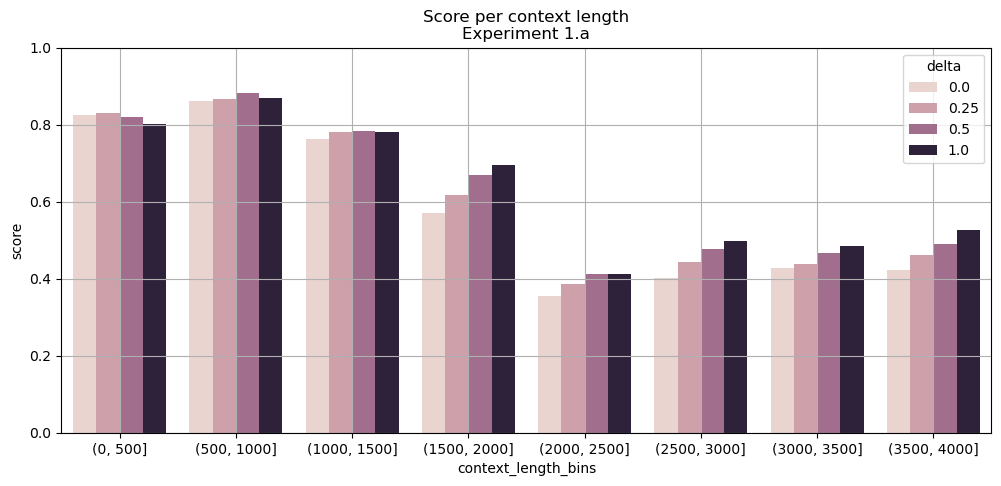

In [ ]:
performance_df = results_df\
    .groupby(['delta', "context_length_bins"])\
    .score\
    .mean()\
    .reset_index()

plt.figure(figsize=(12,5))

sns.barplot(
    performance_df,
    x = 'context_length_bins',
    y = "score",
    hue = "delta"
)

plt.title(f"Score per context length\nExperiment {experiment_name}")
plt.grid()
plt.ylim([0,1])

(0.0, 1.0)

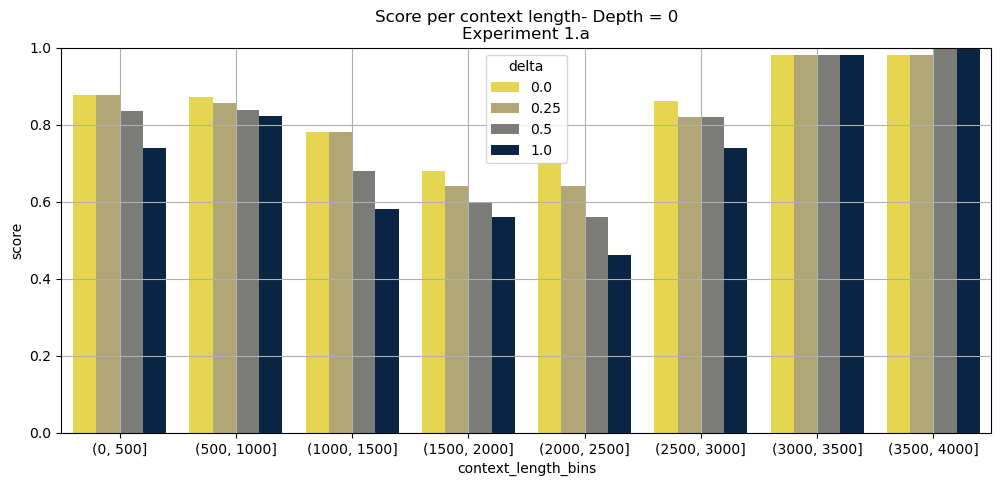

In [ ]:
performance_df = results_df\
    .query("depth == 0")\
    .groupby(['delta', "context_length_bins"])\
    .score\
    .mean()\
    .reset_index()

plt.figure(figsize=(12,5))

sns.barplot(
    performance_df,
    x = 'context_length_bins',
    y = "score",
    hue = "delta",
    palette = 'cividis_r'
)

plt.title(f"Score per context length- Depth = 0\nExperiment {experiment_name}")
plt.grid()

plt.ylim([0,1])

(0.0, 1.0)

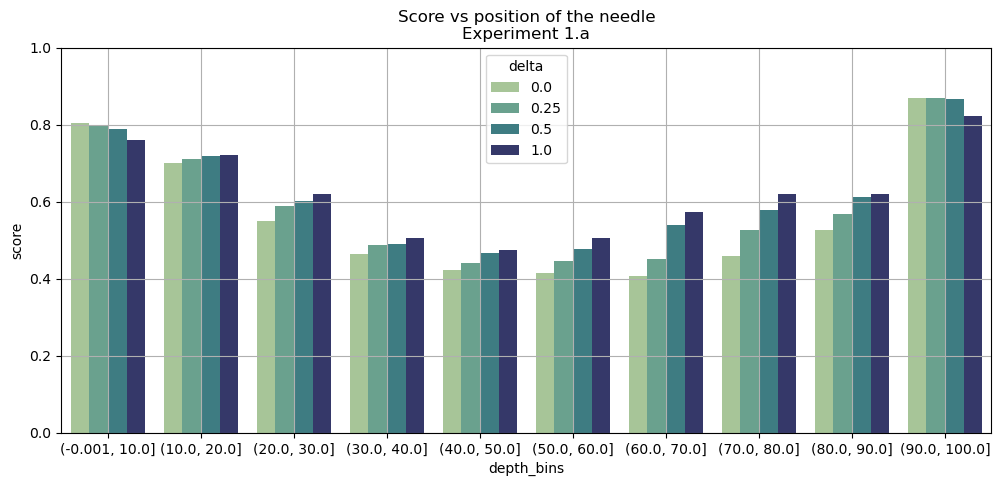

In [ ]:
performance_df = results_df\
    .groupby(['delta', "depth_bins"])\
    .score\
    .mean()\
    .reset_index()

plt.figure(figsize=(12,5))

sns.barplot(
    performance_df,
    x = 'depth_bins',
    y = "score",
    hue = "delta",
    palette = "crest"
)

plt.title(f"Score vs position of the needle\nExperiment {experiment_name}")
plt.grid()
plt.ylim([0,1])

In [ ]:
performance_df = results_df\
    .groupby(['delta', "context_length_bins", "depth_bins"])\
    .score\
    .mean()\
    .reset_index()

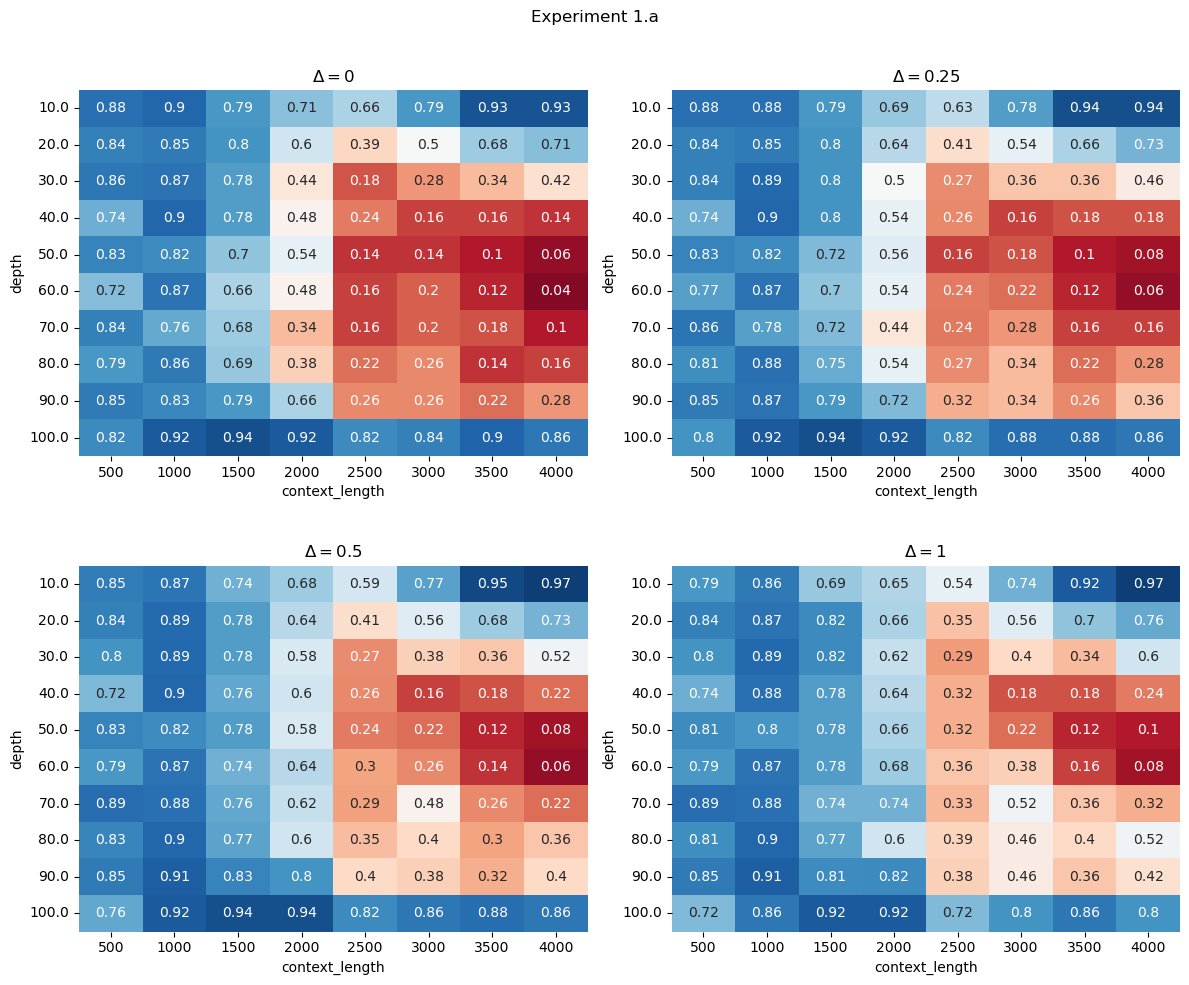

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# List of delta values for each subplot
delta_values = [0, 0.25,0.5, 1]

# Loop over the subplots and delta values
for ax, delta in zip(axes.flat, delta_values):
    heatmap_data = performance_df.query(
        f"delta == {delta}")

    heatmap_data['depth_bins'] = heatmap_data['depth_bins']\
    .apply(lambda x : x.right)

    heatmap_data['context_length_bins'] = heatmap_data['context_length_bins']\
        .apply(lambda x : x.right)

    heatmap_data = heatmap_data\
        .pivot(index="depth_bins", columns="context_length_bins", values="score",)
    
    sns.heatmap(heatmap_data, ax=ax, cmap="RdBu", annot=True, cbar=False, vmin = 0, vmax = 1)
    ax.set_xlabel("context_length")
    ax.set_ylabel("depth")
    ax.set_title(rf"$\Delta = {delta}$")

# Adjust layout
plt.tight_layout()

plt.suptitle(f"Experiment {experiment_name}")
plt.subplots_adjust(top = 0.9)
plt.subplots_adjust(hspace=0.3)

# Show the plot
plt.show()